In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [3]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()

        # Define FS parameters (now as learnable parameters)
        self.h = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.d = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.T = nn.Parameter(torch.randn(num_params))

    def forward(self, x):
        v = x

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

# Swish

K=4

Epoch 1/20000, Loss: 7.919369220733643
Epoch 1001/20000, Loss: 1.9421453475952148
Epoch 2001/20000, Loss: 0.7037518620491028
Epoch 3001/20000, Loss: 0.4074871242046356
Epoch 4001/20000, Loss: 0.2653437554836273
Epoch 5001/20000, Loss: 0.17258320748806
Epoch 6001/20000, Loss: 0.13679057359695435
Epoch 7001/20000, Loss: 0.1156163215637207
Epoch 8001/20000, Loss: 0.09474138915538788
Epoch 9001/20000, Loss: 0.0701366662979126
Epoch 10001/20000, Loss: 0.06430205702781677
Epoch 11001/20000, Loss: 0.06022718921303749
Epoch 12001/20000, Loss: 0.05404452607035637
Epoch 13001/20000, Loss: 0.04684552550315857
Epoch 14001/20000, Loss: 0.0402543805539608
Epoch 15001/20000, Loss: 0.03985203430056572
Epoch 16001/20000, Loss: 0.03985043615102768
Epoch 17001/20000, Loss: 0.03985209763050079
Epoch 18001/20000, Loss: 0.039852891117334366
Epoch 19001/20000, Loss: 0.039852455258369446
Loss values: [7.919369220733643, 5.912282466888428, 4.4272356033325195, 3.3298208713531494, 2.5258936882019043, 1.942145347

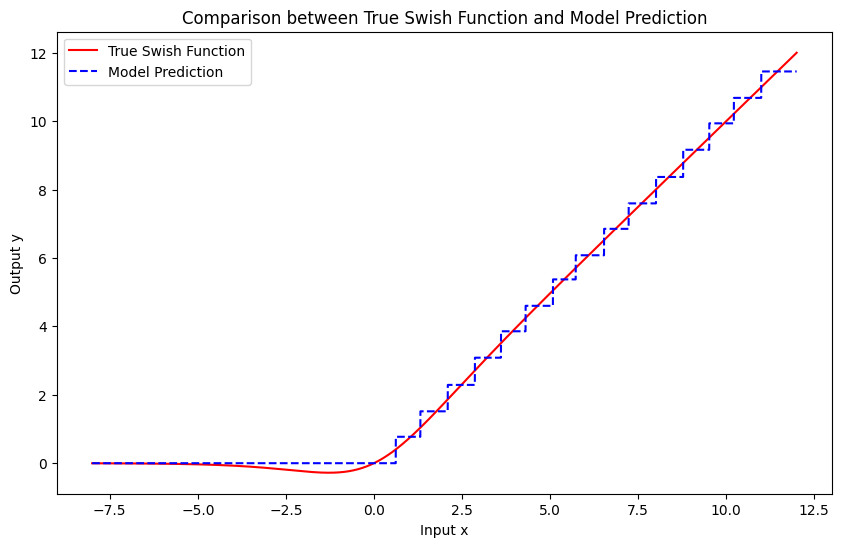

In [4]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

k=8

Epoch 1/20000, Loss: 3.1200478076934814
Epoch 1001/20000, Loss: 0.3600596487522125
Epoch 2001/20000, Loss: 0.1870841085910797
Epoch 3001/20000, Loss: 0.10404811799526215
Epoch 4001/20000, Loss: 0.0710749551653862
Epoch 5001/20000, Loss: 0.04090739041566849
Epoch 6001/20000, Loss: 0.034211620688438416
Epoch 7001/20000, Loss: 0.03182201460003853
Epoch 8001/20000, Loss: 0.029083438217639923
Epoch 9001/20000, Loss: 0.024259567260742188
Epoch 10001/20000, Loss: 0.021322913467884064
Epoch 11001/20000, Loss: 0.017792075872421265
Epoch 12001/20000, Loss: 0.014892632141709328
Epoch 13001/20000, Loss: 0.016205547377467155
Epoch 14001/20000, Loss: 0.01570322923362255
Epoch 15001/20000, Loss: 0.014945752918720245
Epoch 16001/20000, Loss: 0.015109446831047535
Epoch 17001/20000, Loss: 0.015045156702399254
Epoch 18001/20000, Loss: 0.015515429899096489
Epoch 19001/20000, Loss: 0.014924348331987858
Loss values: [3.1200478076934814, 1.4135265350341797, 0.8892984390258789, 0.6287968754768372, 0.468010365

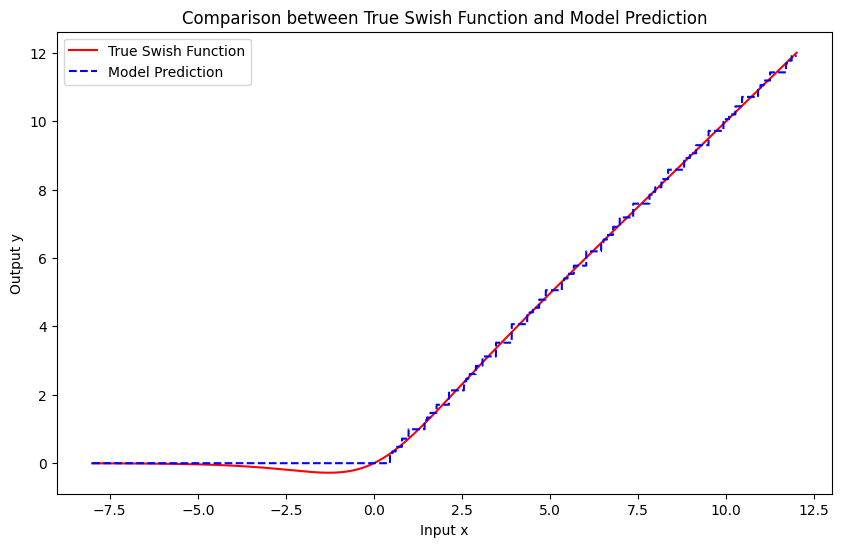

In [6]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

k=12

Epoch 1/20000, Loss: 4.227550983428955
Epoch 1001/20000, Loss: 0.20240619778633118
Epoch 2001/20000, Loss: 0.08771054446697235
Epoch 3001/20000, Loss: 0.039584606885910034
Epoch 4001/20000, Loss: 0.021077269688248634
Epoch 5001/20000, Loss: 0.017448561266064644
Epoch 6001/20000, Loss: 0.015394470654428005
Epoch 7001/20000, Loss: 0.014663578011095524
Epoch 8001/20000, Loss: 0.013950376771390438
Epoch 9001/20000, Loss: 0.013180634006857872
Epoch 10001/20000, Loss: 0.012927534058690071
Epoch 11001/20000, Loss: 0.012489931657910347
Epoch 12001/20000, Loss: 0.01275173295289278
Epoch 13001/20000, Loss: 0.013757091946899891
Epoch 14001/20000, Loss: 0.013924718834459782
Epoch 15001/20000, Loss: 0.012187359854578972
Epoch 16001/20000, Loss: 0.012031354941427708
Epoch 17001/20000, Loss: 0.01179540529847145
Epoch 18001/20000, Loss: 0.011440970003604889
Epoch 19001/20000, Loss: 0.011936236172914505
Loss values: [4.227550983428955, 1.5570895671844482, 0.7744393944740295, 0.45190557837486267, 0.3010

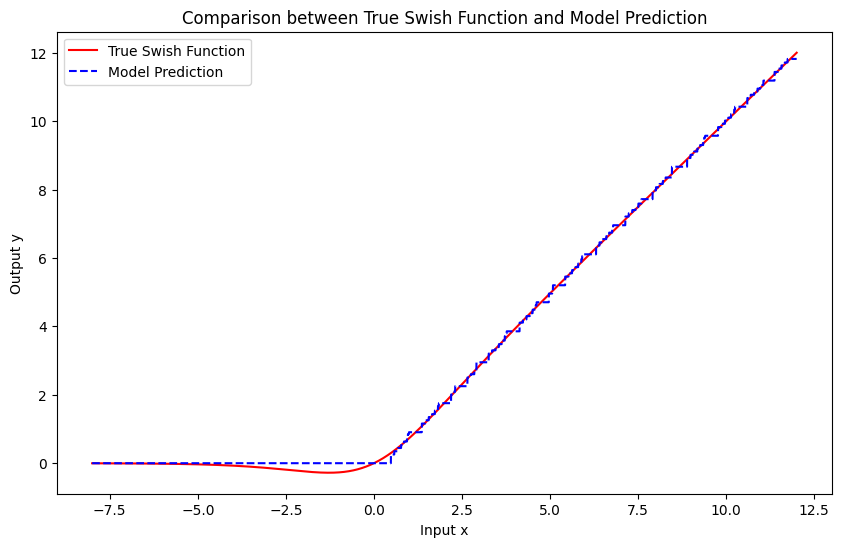

In [7]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=16

Epoch 1/20000, Loss: 3.0343105792999268
Epoch 1001/20000, Loss: 0.09421859681606293
Epoch 2001/20000, Loss: 0.043675560504198074
Epoch 3001/20000, Loss: 0.020244477316737175
Epoch 4001/20000, Loss: 0.010400431230664253
Epoch 5001/20000, Loss: 0.007515230681747198
Epoch 6001/20000, Loss: 0.004342798143625259
Epoch 7001/20000, Loss: 0.0038162763230502605
Epoch 8001/20000, Loss: 0.0031205040868371725
Epoch 9001/20000, Loss: 0.002401416888460517
Epoch 10001/20000, Loss: 0.002319673541933298
Epoch 11001/20000, Loss: 0.001784027903340757
Epoch 12001/20000, Loss: 0.0019258353859186172
Epoch 13001/20000, Loss: 0.0026366589590907097
Epoch 14001/20000, Loss: 0.0030052666552364826
Epoch 15001/20000, Loss: 0.0035955950152128935
Epoch 16001/20000, Loss: 0.0032415117602795362
Epoch 17001/20000, Loss: 0.0030791021417826414
Epoch 18001/20000, Loss: 0.003241512458771467
Epoch 19001/20000, Loss: 0.003358713584020734
Loss values: [3.0343105792999268, 0.6560404896736145, 0.25868022441864014, 0.14628280699

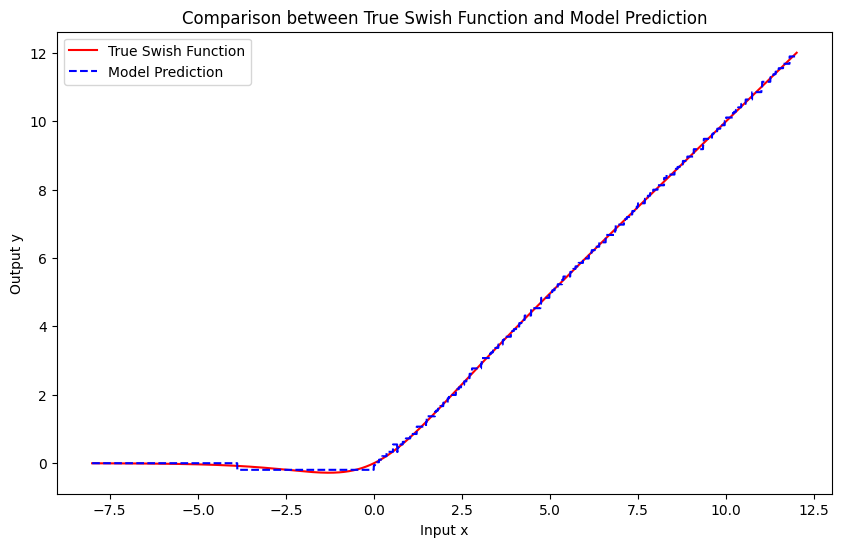

In [8]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=20

Epoch 1/20000, Loss: 14.814522743225098
Epoch 1001/20000, Loss: 0.1803644895553589
Epoch 2001/20000, Loss: 0.12585099041461945
Epoch 3001/20000, Loss: 0.09685859084129333
Epoch 4001/20000, Loss: 0.07024534046649933
Epoch 5001/20000, Loss: 0.0406612865626812
Epoch 6001/20000, Loss: 0.02839101478457451
Epoch 7001/20000, Loss: 0.019268812611699104
Epoch 8001/20000, Loss: 0.010156634263694286
Epoch 9001/20000, Loss: 0.00577313918620348
Epoch 10001/20000, Loss: 0.004181794822216034
Epoch 11001/20000, Loss: 0.003252497874200344
Epoch 12001/20000, Loss: 0.002511108759790659
Epoch 13001/20000, Loss: 0.0024961710441857576
Epoch 14001/20000, Loss: 0.002772682113572955
Epoch 15001/20000, Loss: 0.0011722410563379526
Epoch 16001/20000, Loss: 0.0011597945122048259
Epoch 17001/20000, Loss: 0.001255445764400065
Epoch 18001/20000, Loss: 0.0011902984697371721
Epoch 19001/20000, Loss: 0.0011707197409123182
Loss values: [14.814522743225098, 1.5588712692260742, 0.3444913327693939, 0.23743221163749695, 0.20

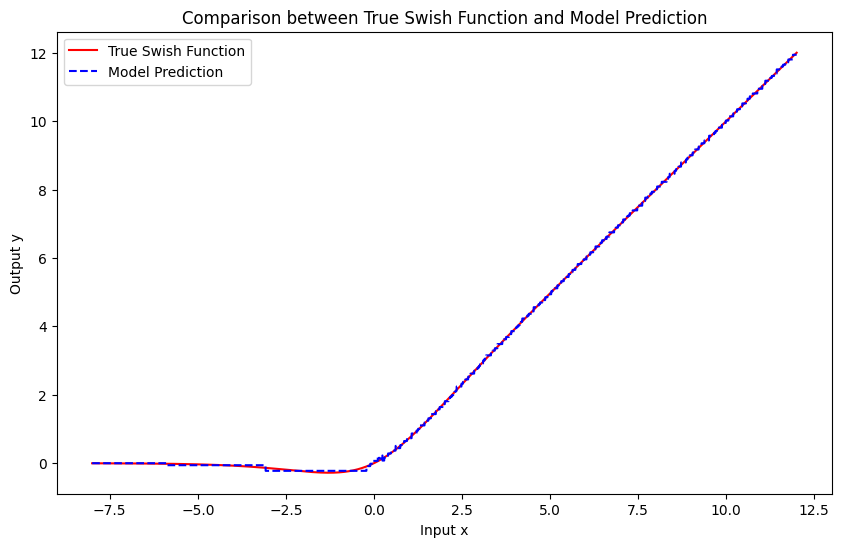

In [9]:
# Instantiate model and initial setup
num_params = 20  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=24

In [ ]:
# Instantiate model and initial setup
num_params = 24  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 2.723832130432129
Epoch 1001/20000, Loss: 0.07692518830299377
Epoch 2001/20000, Loss: 0.03952568396925926
Epoch 3001/20000, Loss: 0.01903349719941616
Epoch 4001/20000, Loss: 0.012422367930412292


In [ ]:
# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

In [ ]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Adjusting training data distribution
x_train = torch.cat((
    torch.linspace(-8, -5, steps=20000),  # Less samples in -8 to -5
    torch.linspace(-5, 2, steps=60000),   # More samples in -5 to 2
    torch.linspace(2, 12, steps=20000)    # Less samples in 2 to 12
)).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Adjusting loss function with weights
#weights = torch.ones_like(y_train)
# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(x_train)
weights[(x_train > -5) & (x_train < 2)] = 5

torch.autograd.set_detect_anomaly(True)

# Training loop
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 100 epochs
    if epoch % 100 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Print final loss
print(f'Final Loss: {loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

손실 함수 가중치 적용, Adam 변경(세밀한 조정을 위해)

In [ ]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='none')  # Use 'none' to manually apply weights later
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Adjusting training data distribution
x_train = torch.cat((
    torch.linspace(-8, -5, steps=20000),  # Less samples in -8 to -5
    torch.linspace(-5, 2, steps=60000),   # More samples in -5 to 2
    torch.linspace(2, 12, steps=20000)    # Less samples in 2 to 12
)).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(y_train)
weights[x_train >= -5] *= 5  # Increase weight for -5 to 2 range

# Training loop
epochs = 100000  # Reduced number of epochs for practicality
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train) * weights  # Apply weights
    weighted_loss = loss.mean()
    weighted_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Weighted Loss: {weighted_loss.item()}')

# Print final loss
print(f'Final Loss: {weighted_loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Enhanced Swish Function Approximation in Target Range')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

2트

In [ ]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='none')  # Use 'none' to manually apply weights later
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Adjusting training data distribution
x_train = torch.cat((
    torch.linspace(-8, -5, steps=20000),  # Less samples in -8 to -5
    torch.linspace(-5, 2, steps=60000),   # More samples in -5 to 2
    torch.linspace(2, 12, steps=20000)    # Less samples in 2 to 12
)).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(y_train)
weights[x_train >= -5] *= 5  # Increase weight for -5 to 2 range

# Training loop
epochs = 100000  # Reduced number of epochs for practicality
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train) * weights  # Apply weights
    weighted_loss = loss.mean()
    weighted_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Weighted Loss: {weighted_loss.item()}')

# Print final loss
print(f'Final Loss: {weighted_loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Enhanced Swish Function Approximation in Target Range')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

In [ ]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='none')  # Use 'none' to manually apply weights later
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Adjusting training data distribution
x_train = torch.linspace(-8, 12, 100000).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(y_train)
weights[x_train >= -5] *= 5  # Increase weight for -5 to 2 range

# Training loop
epochs = 20000  # Reduced number of epochs for practicality
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train) * weights  # Apply weights
    weighted_loss = loss.mean()
    weighted_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Weighted Loss: {weighted_loss.item()}')

# Print final loss
print(f'Final Loss: {weighted_loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Enhanced Swish Function Approximation in Target Range')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

타임스텝을 8로 했을 때 실험

In [ ]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='none')  # Use 'none' to manually apply weights later
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Adjusting training data distribution
x_train = torch.cat((
    torch.linspace(-8, -5, steps=20000),  # Less samples in -8 to -5
    torch.linspace(-5, 2, steps=60000),   # More samples in -5 to 2
    torch.linspace(2, 12, steps=20000)    # Less samples in 2 to 12
)).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(y_train)
weights[x_train >= -5] *= 5  # Increase weight for -5 to 2 range

# Training loop
epochs = 30000  # Reduced number of epochs for practicality
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train) * weights  # Apply weights
    weighted_loss = loss.mean()
    weighted_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Weighted Loss: {weighted_loss.item()}')

# Print final loss
print(f'Final Loss: {weighted_loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Enhanced Swish Function Approximation in Target Range')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

똑같이 만든 코드

In [ ]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 100 epochs
    if epoch % 100 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Print final loss
print(f'Final Loss: {loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

GeLU

In [ ]:
# Instantiate model and initial setup
input_dim = 1
k_neurons = 16  # Select arbitrary number of neurons
num_params = 16  # Select arbitrary number of parameters
model = FS(input_dim, k_neurons, num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training data
x_train = torch.linspace(-10, 10, steps=100).unsqueeze(1)  # Input
y_train = gelu(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 100 epochs
    if epoch % 100 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Print final loss
print(f'Final Loss: {loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = gelu(x_train).squeeze()

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True GeLU Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True GeLU Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

In [ ]:
# Instantiate model and initial setup
input_dim = 1
k_neurons = 12  # Select arbitrary number of neurons
num_params = 12  # Select arbitrary number of parameters
model = FS(input_dim, k_neurons, num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training data
x_train = torch.linspace(-10, 10, steps=100).unsqueeze(1)  # Input
y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

loss_values = []

# Training loop
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Softplus Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Softplus Function and Model Prediction(K=12)')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

In [ ]:
# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = mish(x_train).squeeze()

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Mish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Mish Function and Model Prediction(K=12)')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()